# Introduction

The field of finance is complex and challenging to predict, especially the financial markets which are impacted by various external factors and the actions of multiple investors. Traditional modeling methods, such as linear regression, often fall short in understanding investor behavior or forecasting stock prices. To overcome these difficulties, more advanced models and techniques have been developed for financial instruments like stocks.

We introduce a method for pricing a specific instrument called an option, which utilizes Monte Carlo sampling. By utilizing a quantum algorithm that takes advantage of quantum effects, this technique can achieve a significant increase in speed for pricing the option.

# Financial Instrument

A financial instrument refers to any asset that can be exchanged between various parties. This can include equity instruments such as shares of a company, as well as debt, cash, and contracts.

We can classify financial instruments into multiple groups, such as cash instruments, asset or debt-based instruments and derivative instruments. This challenge will center on derivative instruments. These are called derivatives because their value is derived from the price of another underlying asset. Specifically, we will be looking at a type of derivative called European options.

# Option Price

So, how can we determine the proper price for these options contracts? If we state that a 1-month call option linked to the AAA share price was valued at 5 USD. But is that a fair price? And how do we calculate a fair price for options in general?

The fair price of an option is closely tied to the future price of the underlying asset it is linked to. However, because many of the factors that go into pricing the underlying assets are random, determining the fair price can be challenging. Analytical models exist for basic types of options, but the simplifying assumptions these models require often limit their usefulness. Therefore, numerical methods that estimate the fair price, such as Monte Carlo, have to be used for pricing options, and Monte Carlo is one of the most widely used method.

# The Monte Carlo Method

Monte Carlo methods are a type of computational technique that utilize random sampling and repeated calculations to solve complex problems. Essentially, when faced with a function or equation that involves multiple variables and is difficult to solve analytically, a Monte Carlo approach samples random values for the parameters of the function from a probability distribution. By computing the function multiple times with different sets of randomly sampled values, an expected value for the function can be obtained by averaging all the computed values. This allows for estimation of function values without the need for direct analytical solutions. Monte Carlo simulations are commonly used in finance for evaluating and analyzing investments, portfolios, and financial instruments by simulating the uncertain factors that affect their value. For example, Monte Carlo methods can be used to estimate the fair price of an option by developing a price distribution for the underlying asset, taking into account factors that could influence the price of the underlying asset and hence the value of the option. The ultimate goal of option pricing is to estimate the potential profit or payoff of the option at the expiration date.

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
np.random.seed(42)

#set the parameters
S0 = 52 #underlying asset
K = 56 #strike price
r = 0.02 #return
sigma = 0.2 # volatility 
T = 1 
t = 30 
dt = T / t # incremental time step size
M = 2000 # number of paths to simulate

# Simulating M price paths with t time steps
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt)* np.random.standard_normal((t + 1, M)), axis=0))

#Monte Carlo estimator for the expected payoff
P_call = sum(np.maximum(S[-1] - K, 0)) / M

# Results output
print("The call option value is:  {:0.2f} USD.\n".format(P_call))

The call option value is:  3.19 USD.



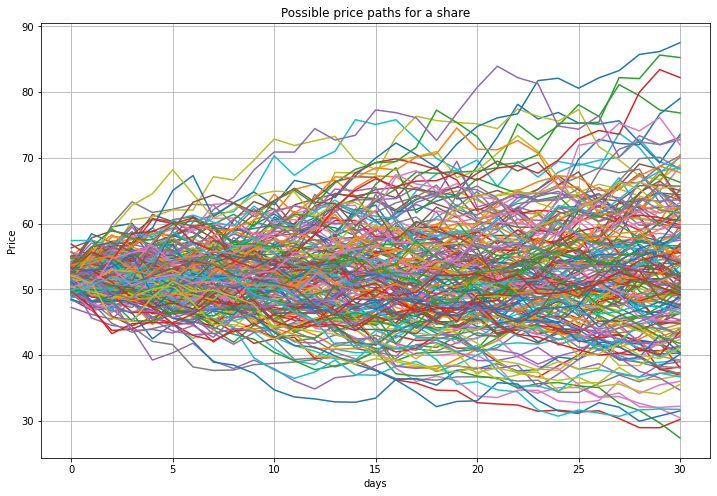

In [37]:
num_paths_to_plot = 200
plt.figure(figsize= (12,8))
plt.plot(S[:, :num_paths_to_plot])
plt.grid(True)
plt.xlabel('days')
plt.ylabel('Price')
plt.title('Possible price paths for a share')
plt.show()

Text(0, 0.5, 'Frequency')

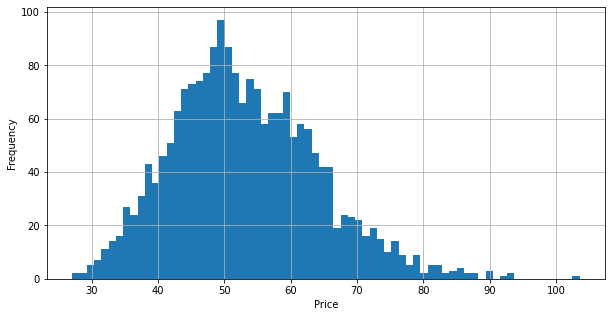

In [38]:
plt.figure(figsize= (10,5))
plt.hist(S[-1], bins=70)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

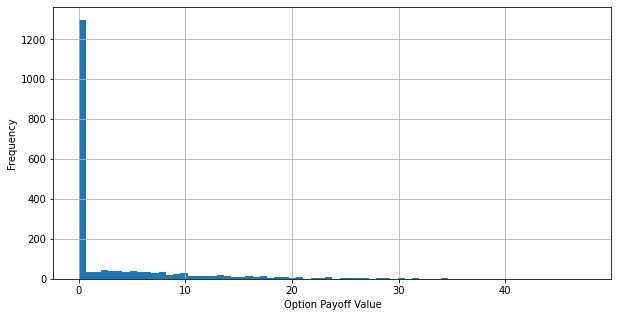

In [39]:
plt.figure(figsize= (10,5))
plt.hist(np.maximum(S[-1] - K, 0), bins=70)
plt.grid(True)
plt.xlabel('Option Payoff Value')
plt.ylabel('Frequency')

# The Quantum Approach

Quantum computing has the potential to revolutionize Monte Carlo methods by providing a more efficient way to solve computationally intensive problems. Traditional Monte Carlo methods are known to be resource-intensive and time-consuming, but quantum computing can potentially offer a faster and more efficient solution. In finance, quantum computing can be applied in various ways such as portfolio optimization, risk assessment and pricing derivatives. One of the promising algorithm is Amplitude Estimation, which can estimate the value of a parameter with a rate of convergence of O(M^-1), where M is the number of samples required. This represents a significant speed-up compared to Monte Carlo methods running on classical computers, which have a convergence rate of O(M^-1/2). The figure shows a graphical representation of this speedup, taken from a research paper on Option Pricing Using Quantum Computers, where the y-axis depicts the estimation error of the function or parameter being modeled, versus the number of samples (M) used to create the estimate.

In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-finance

In [35]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation
from qiskit_finance.circuit.library import LogNormalDistribution, EuropeanCallPricingObjective

A quantum model is made up of circuits composed of operations that manipulate qubits in various ways. The outcome of a quantum circuit when measuring each qubit is determined by the types of rotations used. We know from previous studies that when a qubit is measured, it collapses to a classical outcome of either 0 or 1. However, it is important to note that when qubits are in a superposition state, the outcome of quantum measurements is probabilistic, meaning multiple measurements are needed to obtain an accurate distribution of possible outcomes. These possible outcomes are referred to as basis states, and each one has a probability amplitude associated with it, indicating the likelihood of the basis state being measured.

#Quantum Uncertainty Model

In [40]:
# number of qubits to represent the uncertainty/distribution
num_uncertainty_qubits = 2

# parameters 
S = 52       
strike_price = 56
vol = 0.2    
r = 0.02     
T = 30 / 365  

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value for the spot price; in between, an equidistant discretization is considered
low  = np.maximum(0, mean - 2*stddev) 
high = mean + 2*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

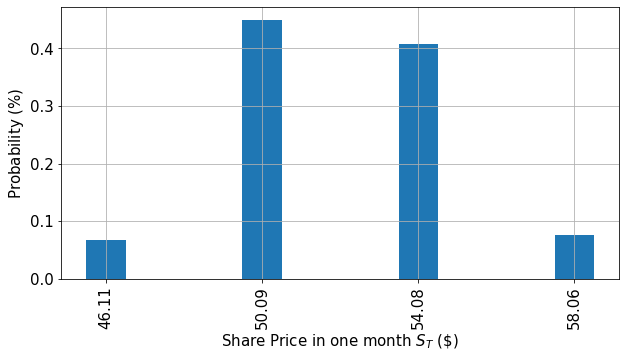

In [41]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.figure(figsize= (10,5))
plt.bar(x, y, width=1)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Share Price in one month $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

# Pay-Off Function

Examining the payout function for our QuantumTech option, we see that it remains at zero until the future stock price (S_t) exceeds the strike price (K). At that point, the payout increases in a linear fashion. The following code demonstrates this.

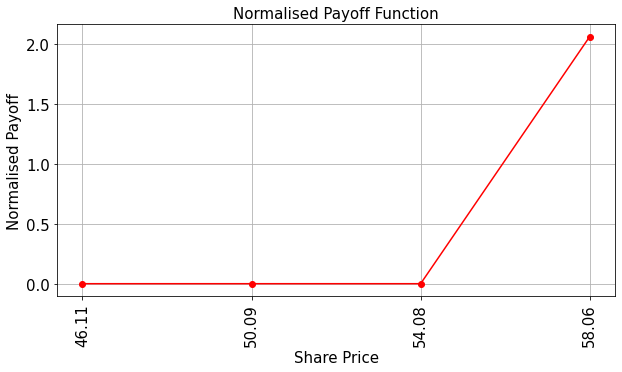

In [42]:
# plot exact payoff function 
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize= (10,5))
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Normalised Payoff Function', size=15)
plt.xlabel('Share Price', size=15)
plt.ylabel('Normalised Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

#Expected Payoff

To determine the expected payout of the option, we can utilize Quantum Amplitude Estimation. The Qiskit library offers built-in algorithms like EuropeanCallPricing and IterativeAmplitudeEstimation to accomplish this task. As this example is simple enough to calculate by hand, we can compare the exact expected value to the results obtained through the quantum approach.

Additionally, we can establish a range of values, known as a confidence interval, around our quantum solution. Since we are working with probability distributions that are inherently random, this interval accounts for this uncertainty. The exact value, estimated value using Amplitude Estimation, estimation error, and confidence interval are shown below. The confidence interval, which is based on the value of alpha, predicts the final output to lie within a specific range.




In [43]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,
                                            bounds=(low, high),
                                            uncertainty_model=uncertainty_model)

In [44]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'

qi = QuantumInstance(Aer.get_backend(simulator), shots=shots, seed_simulator=42, seed_transpiler=42)
problem = european_call_pricing.to_estimation_problem()

# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

In [45]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)

conf_int = np.array(result.confidence_interval_processed)
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (european_call_pricing.interpret(result)))
print('Estimation error:    \t%.4f' %(np.abs(exact_value-european_call_pricing.interpret(result))))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.1557
Estimated value:    	0.1672
Estimation error:    	0.0115
Confidence interval:	[0.1435, 0.1909]


We aim for our model's estimated value to closely match the true value, thus reducing the estimation error to a minimum.